In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import scipy.signal as sps
from scipy.io.wavfile import read as wavread

from IPython.display import Audio

### Overlap-add filtering in Python

Developing the code to perform overlap-add filtering in Python.  Reference will be `scipy.signal.lfilter` and if needed, `scipy.signal.fftconvolve`.  We begin by loading a test signal and then designing a filter as reference.

In [2]:
fs, testsig = wavread('item_01_MA.wav')
Audio(data=testsig, rate=fs)

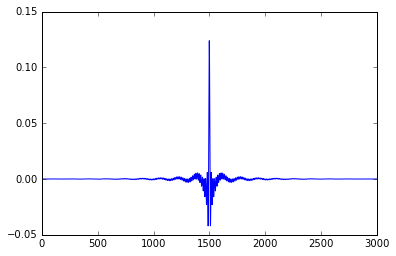

In [3]:
L_I = 3000

testfilt = sps.firwin(L_I, [300, 3300], nyq=fs/2, pass_zero=False)
plt.plot(testfilt)

Now we filter the test signal by the reference filter, and display it.

In [4]:
%timeit sps.lfilter(testfilt, [1, ], testsig)
result1 = sps.lfilter(testfilt, [1, ], testsig)
Audio(data=result1, rate=fs)

1 loop, best of 3: 809 ms per loop


#### Overlap-add filter setup

$L_I$ is the lenght of the impulse response, $L_F$ is the lenth of the FFT, $L_S = L_F - L_I + 1$ is the length of the signal that can be filtered in one shot.  Now we need to figure out into how many sections the input needs to be split; `range` can do that for us, giving the block offsets at the same time.

In [5]:
L_F = 2<<(L_I-1).bit_length()
L_S = L_F - L_I + 1
FDir = np.fft.rfft(testfilt, n=L_F)

L_sig = testsig.shape[0]
offsets = range(0, L_sig, L_S)

print('FFT size {}, filter segment size {}, overall signal length {}.'.format(L_F, L_S, L_sig))

FFT size 8192, filter segment size 5193, overall signal length 436081.


Now do the actual filtering; perform separately the per-block FFT and multiplication by the filter, then reassemble the output signal by addition.

In [6]:
tempresult = [np.fft.irfft(np.fft.rfft(testsig[n:n+L_S], n=L_F)*FDir) for n in offsets]
result2 = np.zeros(L_sig+L_F)
for i, n in enumerate(offsets):
    result2[n:n+L_F] += tempresult[i]
result2 = result2[:L_sig]

Finally, plot the difference and compute the signal-to-noise ratio.

SNR is 297.40652158988644.


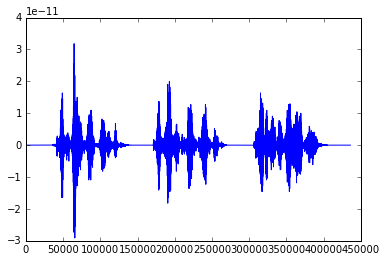

In [7]:
plt.plot(result1-result2)
print('SNR is {}.'.format(10*np.log10(np.sum(result1**2)/np.sum((result1-result2)**2))))

#### Overlap-add function

Now wrap the whole thing up as a function similar to `lfilter`.

In [8]:
def olafilt(b, x):
    L_I = b.shape[0]
    L_F = 2<<(L_I-1).bit_length()   # Find power of 2 larger that 2*L_I
    L_S = L_F - L_I + 1
    L_sig = x.shape[0]
    offsets = range(0, L_sig, L_S)
    FDir = np.fft.rfft(b, n=L_F)
    tempresult = [np.fft.irfft(np.fft.rfft(x[n:n+L_S], n=L_F)*FDir) for n in offsets]
    res = np.zeros(L_sig+L_F)
    for i, n in enumerate(offsets):
        res[n:n+L_F] += tempresult[i]
    return res[:L_sig]

In [9]:
%timeit olafilt(testfilt, testsig)
result3 = olafilt(testfilt, testsig)
print('SNR is {}.'.format(10*np.log10(np.sum(result1**2)/np.sum((result1-result3)**2))))

10 loops, best of 3: 59.9 ms per loop
SNR is 297.40652158988644.


Given test parameters, result appears to be about twice as fast as `scipy.signal.lfilter`.  Now let's also compare to `scipy.signal.fftconvolve`.

In [10]:
%timeit sps.fftconvolve(testfilt, testsig)
result4 = sps.fftconvolve(testfilt, testsig)
result4 = result4[:result1.shape[0]]

10 loops, best of 3: 138 ms per loop


SNR is 294.8053203987104.


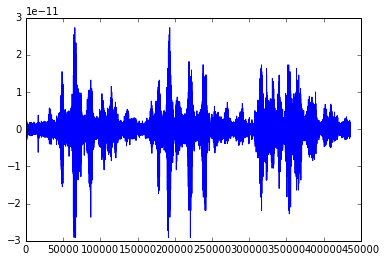

In [11]:
plt.plot(result1-result4)
print('SNR is {}.'.format(10*np.log10(np.sum(result1**2)/np.sum((result1-result4)**2))))